Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/ 

Code for Example 3.28 and Figure 3.19

Model to predict the interarrival times between calls arriving at a call center\
Topics and relevant videos: [Exponential distribution, parametric models](https://www.youtube.com/watch?v=hwEauDzwy9g), [maximum likelihood estimation](https://www.youtube.com/watch?v=kRZR9Amyc64), [histogram, kernel density estimation, nonparametric models](https://www.youtube.com/watch?v=TxB-rbrXMys)

Author: Carlos Fernandez-Granda\
Data source: https://iew.technion.ac.il/serveng/callcenterdata/

In [1]:
# Data is available here: http://iew3.technion.ac.il/serveng/callcenterdata/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import expon

year = 1999

font_size = 15
font_size_legend = 15
font_size_ticks = 15

base_url = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/call_center/"

# Load data
months = ["january","february","march","april","may","june","july","august","september","october","november","december"]
date = {}
time = {}
month_number = {}
for number, month in enumerate(months):
    # data = pd.read_csv ("../data/call_center/" + month + ".txt", sep='\s+')
    file_url = base_url + month + ".txt"
    data = pd.read_csv(file_url, sep='\s+')
    date[month] = data["date"]  
    time[month] = data["vru_entry"]
    month_number[month] = number + 1
hour = time["january"][0].split(":")[0]
hour = time["january"][14].split(":")[0]

In [2]:
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
# Auxiliary function, outputs the number of calls for each day in a month between time_ini and time_end
def extract_call_times(time_ini,time_end,month,verbose):
    call_times = []
    for ind in range(days_in_month[month_number[month]-1]):
        call_times.append([])
    if verbose:
        print("Month: " + month)
    for index, time_call in enumerate(time[month]):
        if verbose:
            print("Date: " + str(date[month][index]) + " Time: " + time_call)
        day = int(date[month][index]) % 100
        hour = int(time_call.split(":")[0])
        if verbose:
            print("Date: " + str(date[month][index]) + " Time: " + time_call + " Day: " + str(day) + " Hour: " + str(hour) )
        if time_ini <= hour and hour < time_end:
            time_in_seconds = hour * 3600 + int(time_call.split(":")[1])*60 + int(time_call.split(":")[2])
            if verbose:
                print("Time in seconds: " + str(time_in_seconds))
            call_times[day-1].append(time_in_seconds)
    return call_times
verbose = False
call_times = extract_call_times(9,10,"october",verbose)

In [3]:
def is_weekend(month_number,day):
    date_object = datetime.date(year,month_number,day)
    weekday = date_object.weekday()
    return weekday == 5 or weekday == 6

In [5]:
def compute_interarrival_times(months,time_ini,time_end,verbose):
    interarrival_times = np.array([])
    for month in months:
        if verbose:
            print("Month: " + month)
        call_times = extract_call_times(time_ini,time_end,month,False)
        for index, calls in enumerate(call_times):
            day = index + 1
            if not is_weekend(month_number[month],day):
                sorted_calls = np.sort(np.array(calls))
                if verbose:
                    print("Sorted calls")
                    print(sorted_calls)
                interarrival_times_day = sorted_calls[1:]-sorted_calls[:-1]
                if verbose:
                    print("Interarrival times")
                    print(interarrival_times_day)
                interarrival_times = np.append(interarrival_times,interarrival_times_day)
    return interarrival_times

verbose = False
interarrival_times = compute_interarrival_times(["january","february"],6,7,verbose)

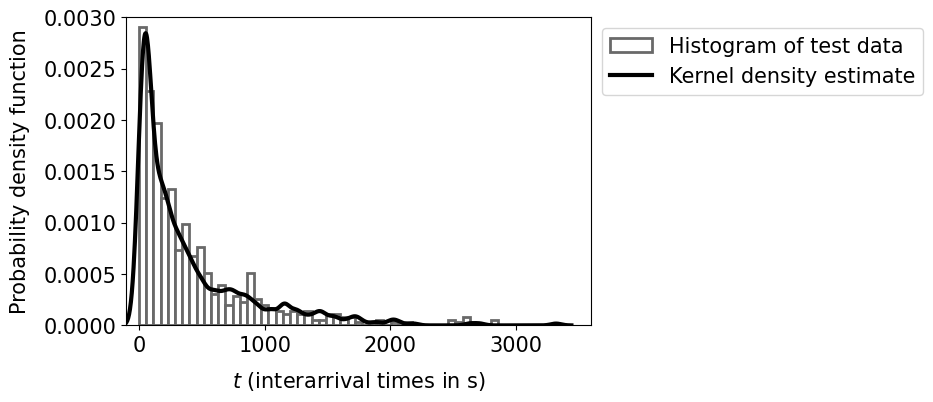

In [6]:
# Nonparametric modeling using kernel density estimation
training_months = ["january","february","march","april","may","june"]
test_months = ["july","august","september","october","november","december"]
time_ini = 6
time_end = 7

interarrival_times = [0,1000,2000,3000]

verbose = False
training_data = compute_interarrival_times(training_months,time_ini,time_end,verbose)
test_data = compute_interarrival_times(test_months,time_ini,time_end,verbose)

n_bins = 50
bw=0.3
x_min = 0
x_max = 3600
y_max = 0.003

plt.figure(figsize=(6,4))
plt.xticks(interarrival_times,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.hist(test_data,bins=n_bins,color='white', edgecolor='dimgray',
          linewidth=2,density=True,label="Histogram of test data")
sns.kdeplot(training_data,bw_adjust=bw,color="black",lw=3,gridsize=1000, legend = False,label="Kernel density estimate")#,color='white', edgecolor='black',linewidth=2)
plt.xlim([x_min-100,x_max])
plt.ylim([0,y_max])
plt.legend(fontsize=font_size,bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('$t$ (interarrival times in s)',fontsize=font_size,labelpad=10)
plt.ylabel('Probability density function',fontsize=font_size,labelpad=10);

ML parameter estimate: 0.00251


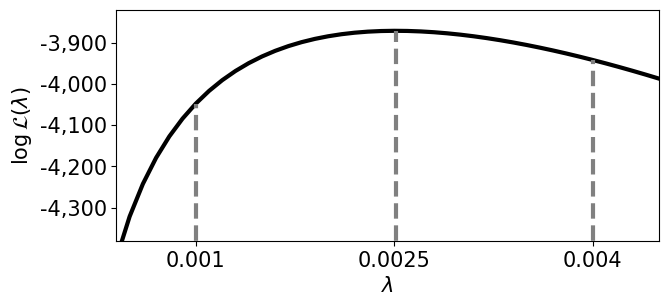

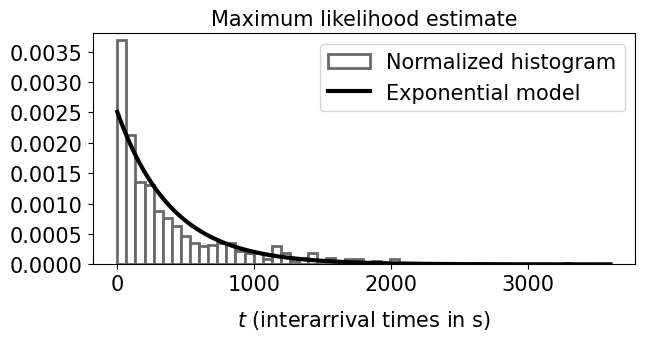

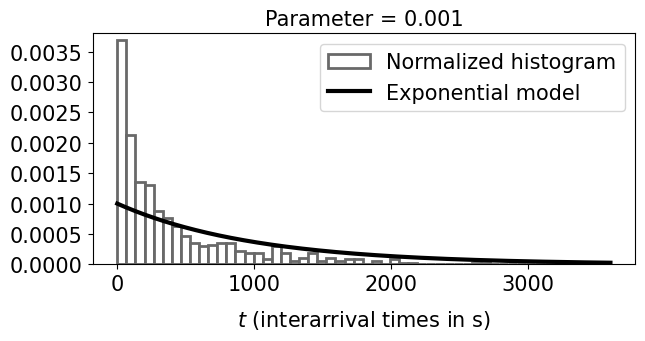

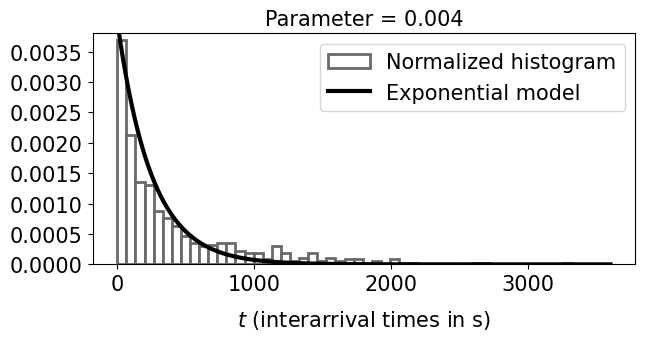

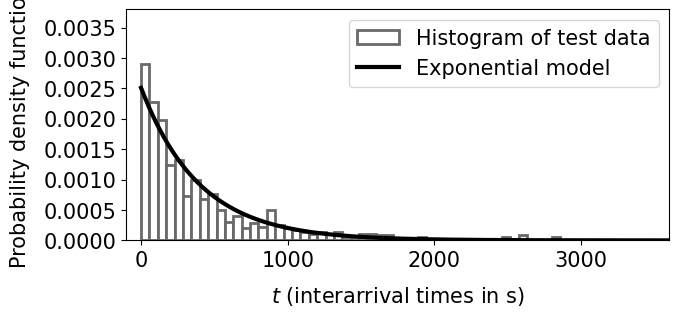

In [7]:
x_min = 0
x_max = 3600
y_max = 0.0038

# Parametric modeling using an exponential distribution
def exponential_model(param,t):
    parametric_fit = expon.pdf(t,0,1/param)
    return parametric_fit

# Log likelihood function
def log_likelihood(param,train_data):
    n = len(train_data)
    llk = n * np.log(param) - param * np.sum(train_data)
    return llk

lambda_min = 0.0004
lambda_max = 0.0045
lambda_vals = np.arange(lambda_min-1e-4,lambda_max+1e-4,1e-4)
log_likelihood_vals = log_likelihood(lambda_vals,training_data)

lambda_ML = 1/np.mean(training_data)
print("ML parameter estimate: {:0.5f}".format(lambda_ML))
other_val_1 = 0.001
other_val_2 = 0.004

step = 1
t=np.arange(x_min,x_max+step,step)

y_max_llk = -3820
y_min_llk = -4380
x_min = 0.6
plt.figure(figsize=(7,3))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(lambda_vals,log_likelihood_vals,linewidth=3,color="black")
plt.vlines(lambda_ML, np.min(log_likelihood_vals), log_likelihood(lambda_ML,training_data), color="gray", linestyles='dashed',lw=3)
plt.vlines(other_val_1, np.min(log_likelihood_vals), log_likelihood(other_val_1,training_data), color="gray", linestyles='dashed',lw=3)
plt.vlines(other_val_2, np.min(log_likelihood_vals), log_likelihood(other_val_2,training_data), color="gray", linestyles='dashed',lw=3)
plt.ylim([y_min_llk,y_max_llk])
plt.xlim([lambda_min,lambda_max])
plt.xlabel(r'$\lambda$',fontsize=font_size)
plt.ylabel(r'$\log \mathcal{L}(\lambda)$',fontsize=font_size)
plt.xticks([other_val_1,0.0025,other_val_2],labels=["0.001","0.0025","0.004"])
plt.yticks([-3900,-4000,-4100,-4200,-4300],labels=["-3,900","-4,000","-4,100","-4,200","-4,300"])

parametric_fit_max_likelihood = exponential_model(lambda_ML,t)
parametric_fit_other_1 = exponential_model(other_val_1,t)
parametric_fit_other_2 = exponential_model(other_val_2,t)

plt.figure(figsize=(7,3))
plt.xticks(interarrival_times,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.hist(training_data,bins=n_bins,color='white', edgecolor='dimgray',
          linewidth=2,density=True,label="Normalized histogram")
plt.plot(t,parametric_fit_max_likelihood,lw=3,color="black",
     label=r'Exponential model')
plt.ylim([0,y_max])
plt.xlabel('$t$ (interarrival times in s)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size_ticks)
plt.title("Maximum likelihood estimate",fontsize=font_size)

plt.figure(figsize=(7,3))
plt.xticks(interarrival_times,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.hist(training_data,bins=n_bins,color='white', edgecolor='dimgray',
          linewidth=2,density=True,label="Normalized histogram")
plt.plot(t,parametric_fit_other_1,lw=3,color="black",
     label=r'Exponential model')
plt.ylim([0,y_max])
plt.xlabel('$t$ (interarrival times in s)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size_ticks)
plt.title("Parameter = "+ str(other_val_1),fontsize=font_size)

plt.figure(figsize=(7,3))
plt.xticks(interarrival_times,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.hist(training_data,bins=n_bins,color='white', edgecolor='dimgray',
          linewidth=2,density=True,label="Normalized histogram")
plt.plot(t,parametric_fit_other_2,lw=3,color="black",
     label=r'Exponential model')
plt.ylim([0,y_max])
plt.xlabel('$t$ (interarrival times in s)',fontsize=font_size,labelpad=10)
plt.legend(fontsize=font_size_ticks)
plt.title("Parameter = "+ str(other_val_2),fontsize=font_size)

plt.figure(figsize=(7,3))
plt.xticks(interarrival_times,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.hist(test_data,bins=n_bins,color='white', edgecolor='dimgray',
          linewidth=2,density=True,label="Histogram of test data")
plt.plot(t,parametric_fit_max_likelihood,lw=3,color="black",
     label=r'Exponential model')
plt.xlim([x_min-100,x_max])
plt.ylim([0,y_max])
plt.legend(fontsize=font_size)
plt.ylabel('Probability density function',fontsize=font_size,labelpad=10)
plt.xlabel('$t$ (interarrival times in s)',fontsize=font_size,labelpad=10);

Mean of data: 30.75
Standard deviation of data: 33.61


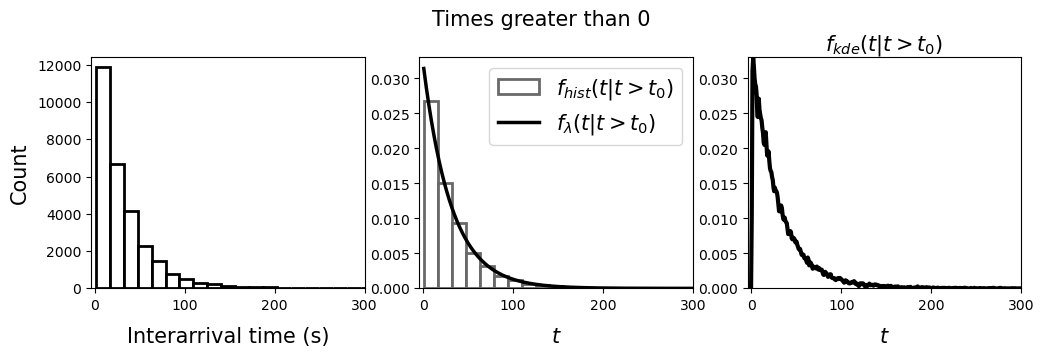

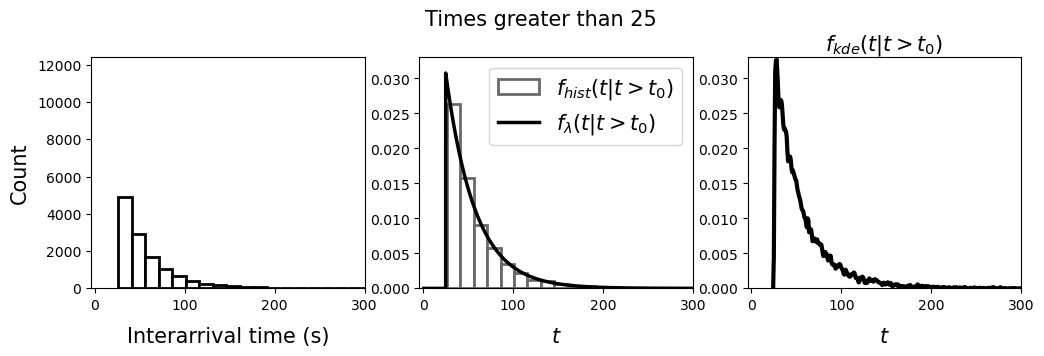

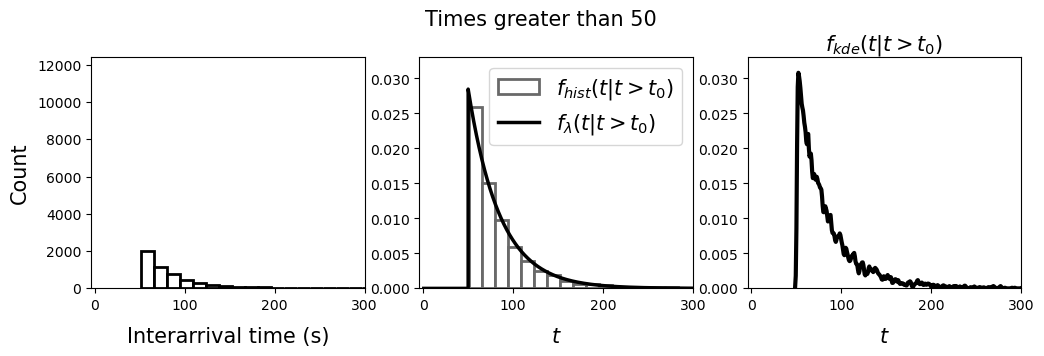

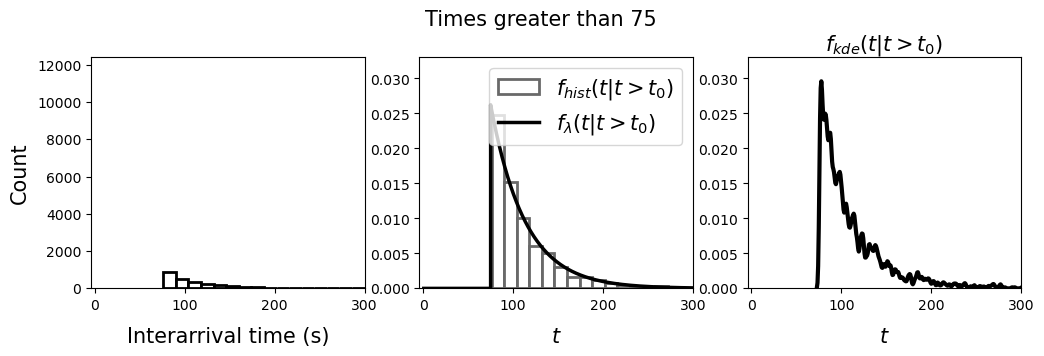

In [8]:
# Verifying memoryless property of exponential distribution in real data
all_months = ["january","february","march","april","may","june","july","august","september","october","november","december"]
time_ini = 9
time_end = 10
data = compute_interarrival_times(all_months,time_ini,time_end,verbose)
times = [1e-5,25,50,75]

print("Mean of data: "+ str(round(np.mean(data),2)))
print("Standard deviation of data: "+ str(round(np.std(data),2)))

interarrival_times_cond = [0,100,200,300]

x_max = 300
y_max = 0.033
y_max_hist = 12400
bw=0.11
conditioned_data = []
for ind,x in enumerate(times):
    data_above_x = data[data > x]
    conditioned_data.append(data_above_x)
    lambda_ML = 1/np.mean(data_above_x-x)
    step = 0.01
    t=np.arange(x_min,x_max+step,step)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),width_ratios=[1,1,1])

    fig.suptitle("Times greater than "+str(int(x)),fontsize=font_size,y = 1.04)
    
    ax1.set_xticks(interarrival_times_cond) 
    ax1.hist(data_above_x,bins=n_bins,color='white', edgecolor='black', linewidth=2,density=False,
             label=r'$f_{hist}(t | t > t_0)$')
    ax1.set_xlim([x_min-5,x_max])
    ax1.set_ylim([0,y_max_hist])
    ax1.set_ylabel("Count",fontsize=font_size,labelpad=5)
    ax1.set_xlabel('Interarrival time (s)',fontsize=font_size,labelpad=10);
    
    ax2.set_xticks(interarrival_times_cond) 
    ax2.hist(data_above_x,bins=n_bins,color='white', edgecolor='dimgray', linewidth=2,density=True,
             label=r'$f_{hist}(t | t > t_0)$')
    ax2.plot(t,expon.pdf(t,x,1/lambda_ML),lw=2.5,color="black",label=r'$f_{\lambda}(t | t > t_0)$')
    ax2.set_xlim([x_min-5,x_max])
    ax2.set_ylim([0,y_max])
    ax2.legend(fontsize=font_size)
    ax2.set_xlabel('$t$',fontsize=font_size,labelpad=10);
    
    ax3.set_xticks(interarrival_times_cond) 
    sns.kdeplot(data[data > x],bw_adjust=bw,color="black",lw=3,gridsize=1000, legend = False,label="x="+str(x),ax=ax3)
    ax3.set_xlim([x_min-5,x_max])
    ax3.set_ylim([0,y_max])
    ax3.set_title(r"$f_{kde}(t | t > t_0)$",fontsize=font_size,pad=5)
    ax3.set_ylabel("")
    ax3.set_xlabel('$t$',fontsize=font_size,labelpad=10);

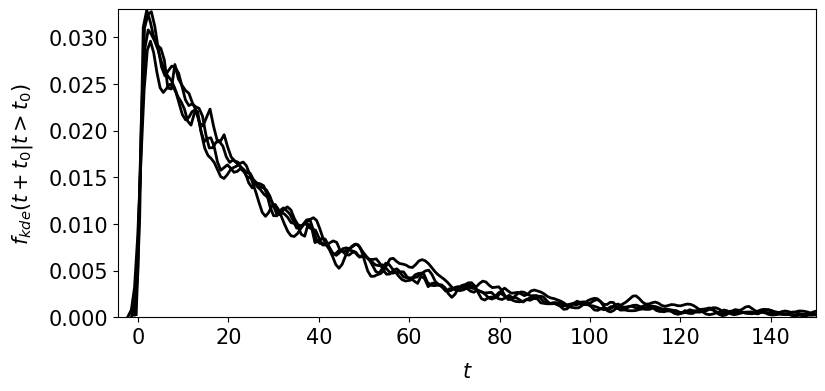

In [9]:
# We superpose the distributions, shifting them all to the origin, to show that the observed interarrival times are
# approximately memoryless
plt.figure(figsize=(9,4))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
for ind,x in enumerate(times):
    data_plot = conditioned_data[ind]-x
    sns.kdeplot(data_plot,bw_adjust=bw,color="black",lw=2,gridsize=1000, legend = False)
    plt.xlim([x_min-5,150])
    plt.ylim([0,y_max])
    plt.ylabel(r"$f_{kde}(t + t_0 | t > t_0)$",fontsize=font_size,labelpad=10)
    plt.xlabel('$t$',fontsize=font_size,labelpad=10);